In [91]:
import pandas as pd
import datetime as dt
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import numpy as np
from uszipcode import SearchEngine
import pickle
import seaborn as sns
from dateutil import rrule
%matplotlib inline

# Load the Data

In [92]:
df = pd.read_csv("data/assessments.csv",low_memory=False)
pd.set_option('display.max_rows', 200)

# Transform Data

In [93]:
# prepare the data 
# the zipcode information contains a typo at row 142359

In [94]:
df1 = df.copy()
df1 = df1.dropna(how='all')
df1 = df1.dropna(subset=['SALEPRICE', 'SALEDATE','PROPERTYCITY','PROPERTYZIP'])
df1 = df1.reset_index(drop=True)
df1.at[142359,'PROPERTYZIP'] =  15017.
df1['date'] = df1['SALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
df1['year'] = df1['date'].dt.year
df1['month'] = df1['date'].dt.month
df1['PROPERTYZIP'] = df1['PROPERTYZIP'].astype('int')
df1['PROPERTYZIP'] = df1['PROPERTYZIP'].astype('str')
df1 =df1[df1['SALEPRICE']>10]

In [95]:
def get_location(df):
    engine = SearchEngine()
    zipcode_dict = {}
    for zipcode in df['PROPERTYZIP'].unique():
        try:
            zc = engine.by_zipcode(zipcode)
            zipcode_dict[zipcode] = [zc.lng, zc.lat]
        except:
            print(zipcode)
            zipcode_dict[zipcode] = [np.nan, np.nan]
    return zipcode_dict

In [96]:
def school_map(df):
    school_ranking = ['North Allegheny', 'Mt Lebanon','Fox Chapel Area','Upper St Clair','South Fayette Twp','Hampton Township','Quaker Valley',
                    'Montour','Pine-Richland','Moon Area','North Hills','Plum Boro','Bethel Park','Riverview','West Jefferson Hills',
                    'Keystone Oaks','Elizabeth Forward','Baldwin Whitehall','Gateway','West Allegheny','South Park','Avonworth','Shaler Area',
                    'Chartiers Valley','Northgate', 'Deer Lakes','Brentwood Boro','Pittsburgh', 'Woodland Hills', 'Steel Valley','Carlynton', 
                    'McKeesport Area','West Mifflin Area','Penn Hills Twp', 'Cornell','Highlands','East Allegheny', 'Clairton City',
                    'Allegheny Valley', 'Sto-Rox', 'South Allegheny','Wilkinsburg Boro']
    ranking = [x for x in range(1,len(school_ranking)+1)]
    ranking_dict = dict(zip(school_ranking, ranking))
    school_missing = [x for x in df.SCHOOLDESC.unique() if x not in school_ranking]
    missing_map = {}
    for zc in df.PROPERTYZIP.unique():
        schools = list(df[df['PROPERTYZIP']==zc]['SCHOOLDESC'].unique())
        for s in schools:
            if s in school_missing:
                if s not in missing_map:
                    missing_map[s] = schools
                    missing_map[s].remove(s)
                else:
                    missing_map[s] += schools
                    missing_map[s].remove(s)
    for key in missing_map:
        missing_map[key] = np.array(list(map(ranking_dict.get, missing_map[key]))).mean()
        school_ranking_dict = dict(zip(list(missing_map.keys())+list(ranking_dict.keys()),list(missing_map.values())+list(ranking_dict.values())))
    return dict(zip(list(missing_map.keys())+list(ranking_dict.keys()),list(missing_map.values())+list(ranking_dict.values())))


In [97]:
# map zip code to longitude and latitude
# map school district to ranking number
zipcode_dict = get_location(df1)
school_ranking_dict= school_map(df1)

In [98]:
class Features_Transformer(object):
    """Class that transform categorical features into numeric features and fill the missing data.
    
    Data cleaning process of trasform original features to numeric features.
    Dummy transform is at the end of the process.
    
    Attributes:
        zipcode_dict: hash map between zip code and longitude, latitude
        school_ranking_dict:  hash map between school district and ranking
    """
    
    def __init__(self, zipcode_dict, school_ranking_dict): 
        
        """Inits Features_Transformer"""
        
        self.zipcode_dict = zipcode_dict
        self.school_ranking_dict = school_ranking_dict 
        
        # ranking list to transform categorical features with ranking
        self.grade_ranking_list = ['XX+','XX','XX-','X+','X','X-','A+','A','A-','B+','B','B-',
                                   'C+','C','C-','D+','D','D-','E+','E','E-']
        self.CDU_ranking_list = ['EXCELLENT', 'VERY GOOD', 'GOOD','AVERAGE','FAIR', 'POOR',
                                 'VERY POOR','UNSOUND']
        
        self.feature_location = []
        self.feature_mean = []
        # 
        self.cat_features = ['TAXDESC','TAXSUBCODE_DESC','OWNERDESC','CLASSDESC','SALEDESC', 
                             'STYLEDESC','EXTFINISH_DESC','ROOFDESC','BASEMENTDESC',
                             'HEATINGCOOLINGDESC']
        self.missing_numeric_features = ['FIREPLACES', 'BSMTGARAGE', 'HALFBATHS', 'ROOF', 
                                         'FULLBATHS', 'BASEMENT', 'TOTALROOMS', 'CONDITION', 
                                         'BEDROOMS', 'EXTERIORFINISH', 'STORIES', 
                                         'FINISHEDLIVINGAREA', 'CARDNUMBER', 'YEARBLT' ]
        self.additional_feature = ['MUNICODE', 'SCHOOLCODE', 'OWNERCODE', 'USECODE', 'LOTAREA', 
                                   'COUNTYBUILDING', 'COUNTYLAND', 'COUNTYTOTAL', 'COUNTYEXEMPTBLDG', 
                                   'LOCALBUILDING', 'LOCALLAND', 'LOCALTOTAL', 'FAIRMARKETBUILDING', 
                                   'FAIRMARKETLAND', 'FAIRMARKETTOTAL']

        self.dummy_features = ['TAXDESC','TAXSUBCODE_DESC', 'OWNERDESC', 'CLASSDESC', 'SALEDESC', 
                               'STYLEDESC','EXTFINISH_DESC','ROOFDESC','BASEMENTDESC',
                               'HEATINGCOOLINGDESC']

    
    def fit(self, X, y=None):
        """fit the features"""
        
        df = pd.DataFrame()
        
        # combine the address
        df['PROPERTYHOUSENUM'] = X['PROPERTYHOUSENUM'].astype('str')
        df['PROPERTYADDRESS'] = X['PROPERTYADDRESS']
        df['PROPERTYCITY'] = X['PROPERTYCITY']
        df['PROPERTYSTATE'] = X['PROPERTYSTATE']
        df['PROPERTYZIP'] = X['PROPERTYZIP'].astype('int')
        df['PROPERTYZIP'] = df['PROPERTYZIP'].astype('str')
        df['address'] = df[['PROPERTYHOUSENUM','PROPERTYADDRESS','PROPERTYCITY','PROPERTYSTATE','PROPERTYZIP']].agg(' '.join, axis=1)
        
        # drop useless features after getting the address
        df = df.drop(columns=['PROPERTYHOUSENUM', 'PROPERTYADDRESS', 'PROPERTYCITY','PROPERTYSTATE'])
        
        # fill the missing date with the later one
        df['PREVSALEDATE'] = X['PREVSALEDATE'].fillna(X['SALEDATE'])
        df['PREVSALEDATE2'] = X['PREVSALEDATE2'].fillna(df['PREVSALEDATE'])
        
        # fill the missing dale price with the later one
        df['SALEPRICE'] = X['SALEPRICE']
        df['PREVSALEPRICE'] = X['PREVSALEPRICE'].fillna(X['SALEPRICE'])
        df['PREVSALEPRICE2'] = X['PREVSALEPRICE2'].fillna(df['PREVSALEPRICE'])
         
        # change date features to datetime object
        df['SALEDATE'] = X['SALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        df['PREVSALEDATE'] = df['PREVSALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        df['PREVSALEDATE2'] = df['PREVSALEDATE2'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        
        # adding timestamp from datetime object
        df['Timestamp0'] = df['SALEDATE'].apply(lambda x: x.timestamp())
        df['Timestamp1'] = df['PREVSALEDATE'].apply(lambda x: x.timestamp())
        df['Timestamp2'] = df['PREVSALEDATE2'].apply(lambda x: x.timestamp())
        
        # drop datetime object
        df = df.drop(columns=['SALEDATE', 'PREVSALEDATE','PREVSALEDATE2'])
        
        # map the school ranking hashmap to school disctrict
        df['SCHOOL_Ranking'] = X['SCHOOLDESC'].map(school_ranking_dict)
        
        # change binary categorical features to 0 and 1
        # missing value is 0
        df['HOMESTEADFLAG'] = X['HOMESTEADFLAG'].notnull().astype('int')
        df['FARMSTEADFLAG'] = X['FARMSTEADFLAG'].notnull().astype('int')
        df['CLEANGREEN'] = X['CLEANGREEN'].notnull().astype('int')
        df['ABATEMENTFLAG'] = X['ABATEMENTFLAG'].notnull().astype('int')
        
        # map the zip code to longitude, latitude 
        # get the locations to fill other features' missing values
        df['longitude'] = df['PROPERTYZIP'].apply(lambda x: zipcode_dict[x][0])
        df['latitude'] = df['PROPERTYZIP'].apply(lambda x: zipcode_dict[x][1])
        df['location']=list(zip(df['longitude'], df['latitude']))
        
        # map GRADE features with ranking
        # fill missing values with location information
        # if anything else is missing, fill it with the mean
        df['GRADE'] = X['GRADE'].map(dict(zip(self.grade_ranking_list, range(1,len(self.grade_ranking_list)+1))))
        self.grade_mean = df['GRADE'].mean()
        self.grade_location =df['location'].map(df[['location','GRADE']].dropna().groupby('location').mean().to_dict()['GRADE'])
        df['GRADE'] = df['GRADE'].fillna(self.grade_location)
        df['GRADE'] = df['GRADE'].fillna(self.grade_mean)
        
        # map CDU features with ranking
        # fill missing values with location information
        # if anything else is missing, fill it with the mean
        df['CDUDESC'] = X['CDUDESC'].map(dict(zip(self.CDU_ranking_list, range(1,len(self.CDU_ranking_list)+1))))
        self.CDU_mean = df['CDUDESC'].mean()
        self.CDU_location = df['location'].map(df[['location','CDUDESC']].dropna().groupby('location').mean().to_dict()['CDUDESC'])
        df['CDUDESC'] = df['CDUDESC'].fillna(self.CDU_location)
        df['CDUDESC'] = df['CDUDESC'].fillna(self.CDU_mean)
        
        # replace None values with NaN in cat_features,
        # prepare for dummy transform
        for feature in self.cat_features:
            df[feature] = X[feature].replace('None',np.nan)
        
        # replace special None values with NaN
        # prepare for dummy transform
        df['CLASSDESC'] = X['CLASSDESC'].replace('OTHER','CLASS_OTHER')
        df['SALEDESC'] = X['SALEDESC'].replace('OTHER','SALE_OTHER')
        df['STYLEDESC'] = X['STYLEDESC'].replace('OTHER','STYLE_OTHER')
        df['HEATINGCOOLINGDESC'] = X['HEATINGCOOLINGDESC'].replace('Other','HEATINGCOOLING_OTHER')
    
        # fill missing values in numeric features with location information
        for i, feature in enumerate(self.missing_numeric_features):
            df[feature] = X[feature]
            self.feature_location.append(df['location'].map(df[['location',feature]].dropna().groupby('location').mean().to_dict()[feature]))
            self.feature_mean.append(df[feature].mean())
            df[feature] = df[feature].fillna(self.feature_location[i])
            df[feature] = df[feature].fillna(self.feature_mean[i])
            if feature != 'FINISHEDLIVINGAREA':
                df[feature] = df[feature].astype('int')
        
        # drop useless features        
        df = df.drop(columns=['location','PROPERTYZIP','address'])
        
        # merge current features with additional_features
        df = pd.concat([df,X[self.additional_feature]],axis=1)
              
        # transform dummy_features using get_dummies
        df_dummy = pd.get_dummies(df[self.dummy_features])
        
        # drop original dummy_features and combine current features with dummy features
        df = df.drop(columns=self.dummy_features)
        df = pd.concat([df,df_dummy],axis=1)

    def transform(self, X, y=None):
        """transform the features"""
        
        df = pd.DataFrame()
        df['PROPERTYHOUSENUM'] = X['PROPERTYHOUSENUM'].astype('str')
        df['PROPERTYADDRESS'] = X['PROPERTYADDRESS']
        df['PROPERTYCITY'] = X['PROPERTYCITY']
        df['PROPERTYSTATE'] = X['PROPERTYSTATE']
        df['PROPERTYZIP'] = X['PROPERTYZIP'].astype('int')
        df['PROPERTYZIP'] = df['PROPERTYZIP'].astype('str')
        
        df['address'] = df[['PROPERTYHOUSENUM','PROPERTYADDRESS','PROPERTYCITY','PROPERTYSTATE','PROPERTYZIP']].agg(' '.join, axis=1)
        df = df.drop(columns=['PROPERTYHOUSENUM', 'PROPERTYADDRESS', 'PROPERTYCITY','PROPERTYSTATE'])
        
        df['PREVSALEDATE'] = X['PREVSALEDATE'].fillna(X['SALEDATE'])
        df['PREVSALEDATE2'] = X['PREVSALEDATE2'].fillna(df['PREVSALEDATE'])
        
        df['SALEPRICE'] = X['SALEPRICE']
        df['PREVSALEPRICE'] = X['PREVSALEPRICE'].fillna(X['SALEPRICE'])
        df['PREVSALEPRICE2'] = X['PREVSALEPRICE2'].fillna(df['PREVSALEPRICE'])
        
        df['SALEDATE'] = X['SALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        df['PREVSALEDATE'] = df['PREVSALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        df['PREVSALEDATE2'] = df['PREVSALEDATE2'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        
        #df['Timestamp0'] = df['SALEDATE'].values.astype(np.int64) // 10 ** 9
        #df['Timestamp1'] = df['PREVSALEDATE'].values.astype(np.int64) // 10 ** 9
        #df['Timestamp2'] = df['PREVSALEDATE2'].values.astype(np.int64) // 10 ** 9
        df['Timestamp0'] = df['SALEDATE'].apply(lambda x: x.timestamp())
        df['Timestamp1'] = df['PREVSALEDATE'].apply(lambda x: x.timestamp())
        df['Timestamp2'] = df['PREVSALEDATE2'].apply(lambda x: x.timestamp())
        
        df = df.drop(columns=['SALEDATE', 'PREVSALEDATE','PREVSALEDATE2'])
        
        df['SCHOOL_Ranking'] = X['SCHOOLDESC'].map(school_ranking_dict)
        
        df['HOMESTEADFLAG'] = X['HOMESTEADFLAG'].notnull().astype('int')
        df['FARMSTEADFLAG'] = X['FARMSTEADFLAG'].notnull().astype('int')
        df['CLEANGREEN'] = X['CLEANGREEN'].notnull().astype('int')
        df['ABATEMENTFLAG'] = X['ABATEMENTFLAG'].notnull().astype('int')
        
        df['longitude'] = df['PROPERTYZIP'].apply(lambda x: zipcode_dict[x][0])
        df['latitude'] = df['PROPERTYZIP'].apply(lambda x: zipcode_dict[x][1])
        df['location']=list(zip(df['longitude'], df['latitude']))
        
        df['GRADE'] = X['GRADE'].map(dict(zip(self.grade_ranking_list, range(1,len(self.grade_ranking_list)+1))))
        df['GRADE'] = df['GRADE'].fillna(self.grade_location)
        df['GRADE'] = df['GRADE'].fillna(self.grade_mean)
    
        df['CDUDESC'] = X['CDUDESC'].map(dict(zip(self.CDU_ranking_list, range(1,len(self.CDU_ranking_list)+1))))
        df['CDUDESC'] = df['CDUDESC'].fillna(self.CDU_location)
        df['CDUDESC'] = df['CDUDESC'].fillna(self.CDU_mean)
        
        for feature in self.cat_features:
            df[feature] = X[feature].replace('None',np.nan)
            
        df['CLASSDESC'] = X['CLASSDESC'].replace('OTHER','CLASS_OTHER')
        df['SALEDESC'] = X['SALEDESC'].replace('OTHER','SALE_OTHER')
        df['STYLEDESC'] = X['STYLEDESC'].replace('OTHER','STYLE_OTHER')
        df['HEATINGCOOLINGDESC'] = X['HEATINGCOOLINGDESC'].replace('Other','HEATINGCOOLING_OTHER')
        
        for i, feature in enumerate(self.missing_numeric_features):
            df[feature] = X[feature]
            df[feature] = df[feature].fillna(self.feature_location[i])
            df[feature] = df[feature].fillna(self.feature_mean[i])
            if feature != 'FINISHEDLIVINGAREA':
                df[feature] = df[feature].astype('int')
                
        df = df.drop(columns=['location','PROPERTYZIP','address'])
        
        df = pd.concat([df,X[self.additional_feature]],axis=1)
        
        df_dummy = pd.get_dummies(df[self.dummy_features])
        df = df.drop(columns=self.dummy_features)
        df = pd.concat([df,df_dummy],axis=1)
       
        return df
    
    def fit_transform(self, X, y=None):
        """fit and transform the features"""
        self.fit(X)
        return self.transform(X)

# Train the Model

In [99]:
# train the model with data before 2016

df_old = df1[df1.year<2016].copy().reset_index(drop=True)
df_old = df_old.drop(columns=['date'])

# Transform the raw data
# seperate features and target
# target is the SALEPRICE
ftf = Features_Transformer(zipcode_dict, school_ranking_dict)
df_old_tran = ftf.fit_transform(df_old)
features_old = list(df_old_tran.columns)
target = 'SALEPRICE'
features_old.remove(target)
for feature in ['PREVSALEPRICE','PREVSALEPRICE2','Timestamp1','Timestamp2']:
    features_old.remove(feature)

X_old = df_old_tran[features_old]
# price change to log(price)
y_old = np.log(df_old_tran[target])

In [100]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

In [101]:
# build a pipeline including normalization and XGB model
# fit the pipeline and predict the log(price)

steps = [('Rescale', StandardScaler()),
         ('tree', XGBRegressor(n_estimators=500, max_depth=11, eta=0.1,
                               subsample=1,colsample_bytree=1))]
pipe = Pipeline(steps)
model = pipe.fit(X_old, y_old)
y_old_pred = model.predict(X_old)
# check the metric of the model
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_old, y_old_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_old, y_old_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_old, y_old_pred)))

train MAE: 2.23e-01
train MSE: 1.32e-01
train R2: 0.940


In [102]:
# calculate the MAE and MSE for the price transform back from log(price)
print('train MAE: {0:.2e}'.format(mean_absolute_error(np.exp(y_old), np.exp(y_old_pred))))
print('train MSE: {0:.2e}'.format(mean_squared_error(np.exp(y_old), np.exp(y_old_pred))))
#print('train R2: {0:.3f}'.format(r2_score(np.exp(y_old), np.exp(y_old_pred))))

train MAE: 2.85e+04
train MSE: 1.19e+11


Text(0.5, 0, 'Importance')

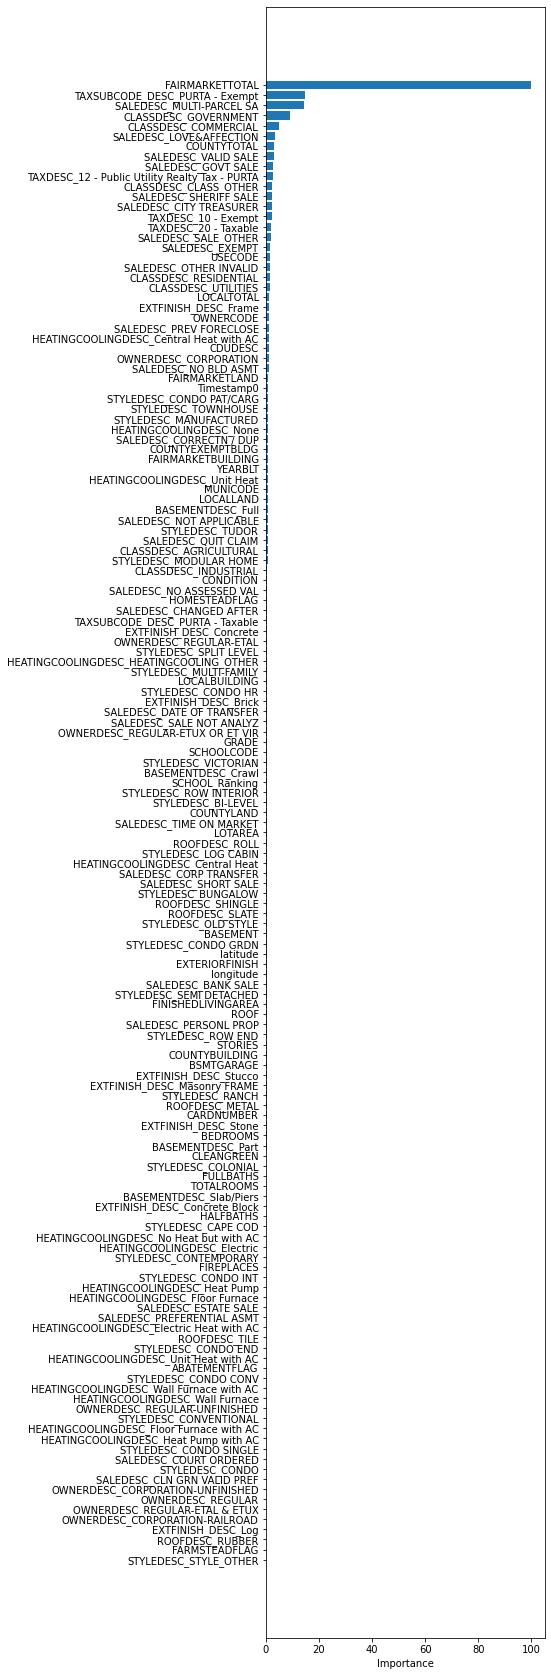

In [355]:
#feature importance
feature_importance = model.named_steps['tree'].feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(5, 30))

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features_old)[sorted_idx])
plt.xlabel('Importance')

In [365]:
np.where(np.array(features_old)[sorted_idx] == 'Timestamp0')

(array([116], dtype=int64),)

In [366]:
#Timestamp feature importance
feature_importance[np.where(np.array(features_old)[sorted_idx] == 'Timestamp0')]

array([0.25125077], dtype=float32)

In [18]:
pickle.dump(model, open("data/xgb_returns.pkl", "wb"))

In [251]:
# build the property univers
# only consider propertis sale date between 2016 and 2020-11
# transfer the raw data
df_recent = df1[(df1['date']>="2016-01-01")&(df1['date']<="2020-11-30")].copy().sort_values("date").reset_index(drop=True)
df_recent_tran = ftf.transform(df_recent)
X_recent = df_recent_tran[features_old].copy()
y_recent = np.log(df_recent_tran[target]).copy()

In [252]:
X_recent['SALEDATE'] = df_recent['SALEDATE'].copy().apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))

In [104]:
# prepare the initial and final date in format of month-year
# and the correlated timestamp for predictions
start, end = df1['date'].min(), df1['date'].max()
start_month_year = dt.datetime.strptime(str(start.year)+'-'+str(start.month), '%Y-%m')
end_month_year = dt.datetime.strptime(str(end.year)+'-'+str(end.month), '%Y-%m')
total_month_time = [dt for dt in rrule.rrule(rrule.MONTHLY, dtstart=start_month_year, until=end_month_year)]
df_time = pd.DataFrame(total_month_time,columns=["date"])
df_time['Timestamp0'] = df_time["date"].apply(lambda x: x.timestamp())
datetime_old = df_time['date'][df_time['date']<'2016'].values
timestamp_old = df_time['Timestamp0'][df_time['date']<'2016'].values
datetime_recent = df_time['date'][(df_time['date']>='2016')&(df_time['date']<='2020-11-01')].values
timestamp_recent = df_time['Timestamp0'][(df_time['date']>='2016')&(df_time['date']<='2020-11-01')].values

In [254]:
# save files for housing returns prediction function: predict_returns.py 
# using multiprocessing CPUs to accelerate the for-loop calculations
pickle.dump(X_recent, open("data/X_recent.pkl", "wb"))
pickle.dump(df_time, open("data/df_time.pkl", "wb"))

#pickle.dump(timestamp_recent, open("data/timestamp_recent.pkl", "wb"))
#pickle.dump(timestamp_old, open("data/timestamp_old.pkl", "wb"))

In [371]:
y_final = []
mean_list = []
sum_list = []
std_list = []
for i, y in enumerate(y_pred_list):
    #print(i)
    k = (df_time[(df_time['date']>=str(X_recent.YEARBLT.iloc[i])) & (df_time['date']<=X_recent.SALEDATE.iloc[i])]).shape[0]
    y_new = y_pred_list[i][-k:]
    log_return = (y_new[1:]-np.roll(y_new,1)[1:])
    mean = log_return.mean()
    sum_ = log_return.sum()
    std = log_return.std()
    y_final.append(y_new[-1])
    mean_list.append(mean)
    std_list.append(std*(len(y_new)**0.5))
    sum_list.append(sum_)

In [339]:
df_invest = pd.DataFrame ([df_recent.PARID.values,df_recent.date.values, df_recent.SALEPRICE.values,y_final,mean_list,std_list, sum_list,df_recent.YEARBLT]).transpose()
df_invest.columns = ['PARID','SALEDATE', 'SALEPRICE', 'log(SALEPRICE)_pred', 'log_return_mean', 'STD','log_return','year_built']
# calculate log return - 3* std as a threshold
df_invest['log_return-3*STD'] = df_invest['log_return']-3*df_invest['STD']
df_invest

,PARID,SALEDATE,SALEPRICE,log(SALEPRICE)_pred,log_return_mean,STD,log_return,year_built,log_return-3*STD
0,0231N00039000000,2016-01-01,30000.0,9.323092,0.00138,2.219004,1.589216,1920.0,-5.067797
1,0174E00013000000,2016-01-01,16000.0,9.429649,0.000603,1.955125,0.839338,1900.0,-5.026037
2,0124P00139000000,2016-01-01,24000.0,10.59728,0.001106,1.971065,1.273876,1920.0,-4.639319
3,0124P00140000000,2016-01-01,24000.0,12.018023,0.001834,3.29214,1.012604,NaN,-8.863815
4,0169S00371000000,2016-01-01,250875.0,12.307631,0.001595,2.000497,1.550497,1935.0,-4.450992
...,...,...,...,...,...,...,...,...,...
97196,0567D00071000000,2020-11-30,148000.0,10.836209,0.000849,2.274197,1.027492,1920.0,-5.795099
97197,0640K00328000000,2020-11-30,125000.0,11.208313,0.002487,0.735564,1.994524,1954.0,-0.212167
97198,0820S00062000000,2020-11-30,850000.0,13.552358,0.005185,0.292948,0.611836,2011.0,-0.267007
97199,0713D00609320700,2020-11-30,110000.0,11.302082,0.003173,1.536771,1.745084,1975.0,-2.86523


In [340]:
df_invest1 = df_invest[df_invest['log_return-3*STD']>0].sort_values(['SALEDATE','log_return-3*STD'],ascending=[True, False])
id_index = df_invest1.index
id_index = id_index.sort_values()
df_invest1 =df_invest1.reset_index(drop=True)
df_invest1["SALEPRICE_pred"] = [np.exp(x) for x in df_invest1["log(SALEPRICE)_pred"].values]
df_invest1

,PARID,SALEDATE,SALEPRICE,log(SALEPRICE)_pred,log_return_mean,STD,log_return,year_built,log_return-3*STD,SALEPRICE_pred
0,1242P00118000000,2016-01-01,189000.0,12.104669,0.005463,0.874475,2.687612,1975.0,0.064186,180713.578125
1,0572C00007000000,2016-01-04,145000.0,11.650342,0.006135,0.72037,2.797767,1978.0,0.636656,114730.585938
2,0087J00232000000,2016-01-06,119000.0,11.902581,0.00277,0.840533,2.525909,1940.0,0.004311,147647.234375
3,0157R00228000000,2016-01-07,240000.0,12.35444,0.004084,0.476124,2.058249,1974.0,0.629877,231987.718750
4,0772S00083000000,2016-01-07,165000.0,12.0578,0.006566,1.072393,3.230706,1975.0,0.013527,172439.250000
...,...,...,...,...,...,...,...,...,...,...
3953,0098J00238000000,2020-11-30,199000.0,12.083617,0.002164,0.767715,2.488562,1925.0,0.185415,176949.078125
3954,0860G00140000000,2020-11-30,279795.0,12.593179,0.002595,0.487824,1.64523,1968.0,0.181759,294542.562500
3955,0066R00088000000,2020-11-30,120000.0,11.648394,0.002643,0.63801,2.088041,1955.0,0.174012,114507.281250
3956,0137E00214000000,2020-11-30,172000.0,11.87258,0.003011,0.745686,2.342649,1956.0,0.105589,143283.375000


In [341]:
total_price = 0
for i, price in enumerate(df_invest1.SALEPRICE_pred):
    if total_price < 5000000:
        total_price += price
    else:
        break
df_best = df_invest1.iloc[:i-1,:][['PARID','SALEDATE', 'SALEPRICE','SALEPRICE_pred','STD','log_return','log_return-3*STD','year_built']]
# calculate the total investment values
print("Best investment total prediction during 2016-2020: ${}".format(df_best["SALEPRICE_pred"].sum()))
print("Best investment total sale price during 2016-2020: ${}".format(df_best["SALEPRICE"].sum()))
df_best

Best investment total prediction during 2016-2020: $4757989.5
Best investment total sale price during 2016-2020: $4967100.0


,PARID,SALEDATE,SALEPRICE,SALEPRICE_pred,STD,log_return,log_return-3*STD,year_built
0,1242P00118000000,2016-01-01,189000.0,180713.578125,0.874475,2.687612,0.064186,1975.0
1,0572C00007000000,2016-01-04,145000.0,114730.585938,0.72037,2.797767,0.636656,1978.0
2,0087J00232000000,2016-01-06,119000.0,147647.234375,0.840533,2.525909,0.004311,1940.0
3,0157R00228000000,2016-01-07,240000.0,231987.718750,0.476124,2.058249,0.629877,1974.0
4,0772S00083000000,2016-01-07,165000.0,172439.250000,1.072393,3.230706,0.013527,1975.0
5,1004K00036000000,2016-01-08,527500.0,479356.187500,0.740151,2.490337,0.269885,2004.0
6,0926D00060000000,2016-01-08,216000.0,215521.734375,0.814258,2.689498,0.246725,1977.0
7,0150S00096036900,2016-01-08,119000.0,118873.117188,0.620317,1.97939,0.11844,1974.0
8,0170E00097000000,2016-01-11,250000.0,268939.062500,0.500616,2.366297,0.86445,1968.0
9,0550J00162000000,2016-01-11,98000.0,100808.984375,0.646287,2.128838,0.189977,1938.0


In [119]:
# show the #3126 property as an example
log_return = (y_pred_list[3126][1:]-np.roll(y_pred_list[3126],1)[1:])
mean, std = log_return.sum(), log_return.std()*np.sqrt(len(log_return))

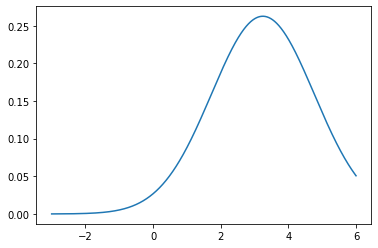

In [120]:
# plot the Normal distribution of total log returns
from scipy.stats import norm
x = np.arange(-3, 6, 0.001)
plt.plot(x, norm.pdf(x, mean, std))